<a href="https://colab.research.google.com/github/Seonghoon-Yu/Paper_Review_and_Implementation_in_PyTorch/blob/master/Classification/PreAct_ResNet(2016).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('pre-act-resnet')

Mounted at pre-act-resnet


# 1. 데이터셋 불러오기
데이터셋은 torchvision 패키지에서 제공하는 STL10 dataset을 이용하겠습니다. STL10 dataset은 10개의 label을 갖으며 train dataset 5000개, test dataset 8000개로 구성됩니다.

In [3]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [4]:
# specift the data path
path2data = '/content/pre-act-resnet/MyDrive/data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

Files already downloaded and verified
Files already downloaded and verified
5000
8000


In [5]:
# define image transformation
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(224)
])

train_ds.transform = transformation
val_ds.transform = transformation

In [6]:
# create dataloader
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=True)

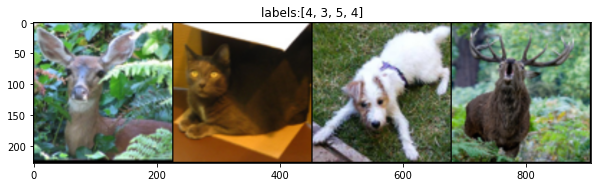

In [7]:
# display sample images
def show(img, y=None, color=True): 
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels:' + str(y))

np.random.seed(3)
torch.manual_seed(0)

grid_size = 4
rnd_ind = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [train_ds[i][1] for i in rnd_ind]

plt.figure(figsize=(10,10))
x_grid = utils.make_grid(x_grid, nrow=4, padding=2)
show(x_grid, y_grid)

# 2. 모델 구축하기
코드는 https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/preactresnet.py 을 참고했습니다.

In [8]:
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, 1, stride=stride),
            
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1),

            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, 1)
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, 1, stride=stride)

    def forward(self, x):
        x_shortcut = self.shortcut(x)
        x_residual = self.residual(x)
        return x_shortcut + x_residual



class PreActResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10, init_weights=True):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1)
        )

        self.conv2 = self._make_layers(num_blocks[0], 64, 1)
        self.conv3 = self._make_layers(num_blocks[1], 128, 2)
        self.conv4 = self._make_layers(num_blocks[2], 256, 2)
        self.conv5 = self._make_layers(num_blocks[3], 512, 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * BottleNeck.expansion, num_classes)

        # weights Initialization
        if init_weights:
            self._initialize_weights()
        
    def _make_layers(self, num_blocks, out_channels, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for stride in strides:
            layers.append(BottleNeck(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * BottleNeck.expansion
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def PreAct_ResNet50():
    return PreActResNet([3,4,6,3])

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PreAct_ResNet50().to(device)

In [10]:
summary(model, (3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 256, 112, 112]          16,640
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]           4,160
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,928
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
           Conv2d-14        [-1, 256, 1

# 3. 학습하기

In [11]:
# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history={'train': [], 'val': []}
    metric_history={'train': [], 'val': []}

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            print('Get Best val loss!!')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val_loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)
    
    return model, loss_history, metric_history

In [12]:
# define the training parameters
params_train = {
    'num_epochs':20,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [13]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/19, current lr=0.001
Get Best val loss!!
train loss: 2.378964, val_loss: 1.825338, accuracy: 29.12, time: 4.8207 min
----------
Epoch 1/19, current lr=0.001
Get Best val loss!!
train loss: 1.819337, val_loss: 1.809731, accuracy: 30.03, time: 9.6918 min
----------
Epoch 2/19, current lr=0.001
train loss: 1.753082, val_loss: 1.912175, accuracy: 27.31, time: 14.5577 min
----------
Epoch 3/19, current lr=0.001
Get Best val loss!!
train loss: 1.730178, val_loss: 1.719261, accuracy: 29.38, time: 19.4208 min
----------
Epoch 4/19, current lr=0.001
train loss: 1.674870, val_loss: 1.739207, accuracy: 30.05, time: 24.2815 min
----------
Epoch 5/19, current lr=0.001
Get Best val loss!!
train loss: 1.653581, val_loss: 1.639378, accuracy: 34.21, time: 29.1417 min
----------
Epoch 6/19, current lr=0.001
Get Best val loss!!
train loss: 1.591893, val_loss: 1.568335, accuracy: 38.30, time: 33.9973 min
----------
Epoch 7/19, current lr=0.001
train loss: 1.555602, val_loss: 1.630906, accuracy: 36

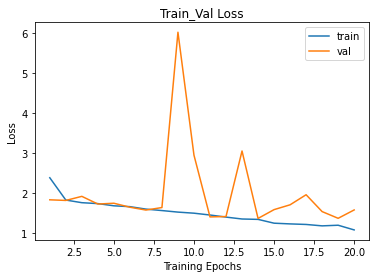

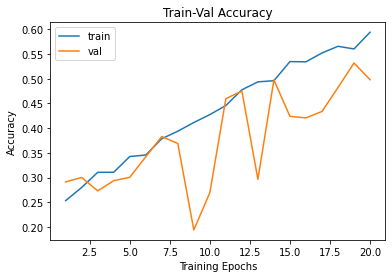

In [15]:
# Train-Val progress
num_epochs=params_train['num_epochs']

# plot loss progress
plt.title('Train_Val Loss')
plt.plot(range(1,num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1,num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()